In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

In [2]:
df = pl.read_csv("../data/selected_features_inflation.csv", infer_schema_length=10000, dtypes={"ANDENOx": pl.Float64})

display(df.head())

print("\nDataframe info:")
print(f"Shape: {df.shape}")
print(f"Column names: {df.columns}")
print(f"Data types:\n{df.dtypes}")

/var/folders/jb/ckb_b9f94m5dvhsy6d9bwn800000gn/T/ipykernel_85202/3781630620.py:1: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  df = pl.read_csv("../data/selected_features_inflation.csv", infer_schema_length=10000, dtypes={"ANDENOx": pl.Float64})


sasdate,CPIAUCSL_MOM,TOTRESNS_MOM,OILPRICEx_MOM,DDURRG3M086SBEA_YOY,DPCERA3M086SBEA_YOY,OILPRICEx_YOY,S&P PE ratio_MOM,AMDMUOx_YOY,ACOGNO_MOM,CES3000000008_YOY,CES0600000007,W875RX1_MOM,IPB51222S,TWEXAFEGSMTHx_MOM,IPNMAT_MOM,RPI_YOY,BUSINVx_MOM,WPSFD49207_MOM,ANDENOx_MOM,CLAIMSx_MOM,WPSID62_MOM,PERMITNE,CUSR0000SAD_YOY,CPITRNSL_MOM,UEMP15T26_MOM,EXSZUSx_MOM
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64
"""1959-01-01""",null,null,null,null,null,null,null,null,null,null,39.8,null,19.9173,null,null,null,null,null,null,null,null,null,null,null,null,null
"""1959-02-01""",-0.034471,-1.587302,0.0,null,null,null,-0.149749,null,null,null,39.7,0.362737,19.8631,null,1.751079,null,0.344274,0.302115,null,-2.78963,-0.632911,null,null,0.341297,-8.249158,0.025509
"""1959-03-01""",-0.103448,-1.075269,-1.0,null,null,null,3.155764,null,null,null,40.0,0.735173,19.9986,null,1.502019,null,0.514639,0.0,null,-7.991292,0.318471,null,null,0.680272,-2.752294,0.220249
"""1959-04-01""",0.034518,1.630435,0.0,null,null,null,1.440165,null,null,null,40.2,0.705345,20.0799,null,3.09727,null,1.342587,0.0,null,-5.351724,0.634921,null,null,0.337838,-23.018868,-0.004627
"""1959-05-01""",0.207039,-0.534759,0.0,null,null,null,1.147522,null,null,null,40.3,0.663968,20.3779,null,0.898387,null,0.572583,0.301205,null,0.218738,-0.630915,null,null,0.0,-4.411765,0.004627



Dataframe info:
Shape: (793, 27)
Column names: ['sasdate', 'CPIAUCSL_MOM', 'TOTRESNS_MOM', 'OILPRICEx_MOM', 'DDURRG3M086SBEA_YOY', 'DPCERA3M086SBEA_YOY', 'OILPRICEx_YOY', 'S&P PE ratio_MOM', 'AMDMUOx_YOY', 'ACOGNO_MOM', 'CES3000000008_YOY', 'CES0600000007', 'W875RX1_MOM', 'IPB51222S', 'TWEXAFEGSMTHx_MOM', 'IPNMAT_MOM', 'RPI_YOY', 'BUSINVx_MOM', 'WPSFD49207_MOM', 'ANDENOx_MOM', 'CLAIMSx_MOM', 'WPSID62_MOM', 'PERMITNE', 'CUSR0000SAD_YOY', 'CPITRNSL_MOM', 'UEMP15T26_MOM', 'EXSZUSx_MOM']
Data types:
[String, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Int64, Float64, Float64, Float64, Float64]


In [3]:
df_with_lag = df.with_columns([
    pl.col(col).shift(lag).alias(f"{col}_lag{lag}") 
    for col in df.columns 
    if col != "sasdate"
    for lag in range(1, 6)  # Create lags 1 through 5
])

df_with_lag

sasdate,CPIAUCSL_MOM,TOTRESNS_MOM,OILPRICEx_MOM,DDURRG3M086SBEA_YOY,DPCERA3M086SBEA_YOY,OILPRICEx_YOY,S&P PE ratio_MOM,AMDMUOx_YOY,ACOGNO_MOM,CES3000000008_YOY,CES0600000007,W875RX1_MOM,IPB51222S,TWEXAFEGSMTHx_MOM,IPNMAT_MOM,RPI_YOY,BUSINVx_MOM,WPSFD49207_MOM,ANDENOx_MOM,CLAIMSx_MOM,WPSID62_MOM,PERMITNE,CUSR0000SAD_YOY,CPITRNSL_MOM,UEMP15T26_MOM,EXSZUSx_MOM,CPIAUCSL_MOM_lag1,CPIAUCSL_MOM_lag2,CPIAUCSL_MOM_lag3,CPIAUCSL_MOM_lag4,CPIAUCSL_MOM_lag5,TOTRESNS_MOM_lag1,TOTRESNS_MOM_lag2,TOTRESNS_MOM_lag3,TOTRESNS_MOM_lag4,TOTRESNS_MOM_lag5,…,ANDENOx_MOM_lag4,ANDENOx_MOM_lag5,CLAIMSx_MOM_lag1,CLAIMSx_MOM_lag2,CLAIMSx_MOM_lag3,CLAIMSx_MOM_lag4,CLAIMSx_MOM_lag5,WPSID62_MOM_lag1,WPSID62_MOM_lag2,WPSID62_MOM_lag3,WPSID62_MOM_lag4,WPSID62_MOM_lag5,PERMITNE_lag1,PERMITNE_lag2,PERMITNE_lag3,PERMITNE_lag4,PERMITNE_lag5,CUSR0000SAD_YOY_lag1,CUSR0000SAD_YOY_lag2,CUSR0000SAD_YOY_lag3,CUSR0000SAD_YOY_lag4,CUSR0000SAD_YOY_lag5,CPITRNSL_MOM_lag1,CPITRNSL_MOM_lag2,CPITRNSL_MOM_lag3,CPITRNSL_MOM_lag4,CPITRNSL_MOM_lag5,UEMP15T26_MOM_lag1,UEMP15T26_MOM_lag2,UEMP15T26_MOM_lag3,UEMP15T26_MOM_lag4,UEMP15T26_MOM_lag5,EXSZUSx_MOM_lag1,EXSZUSx_MOM_lag2,EXSZUSx_MOM_lag3,EXSZUSx_MOM_lag4,EXSZUSx_MOM_lag5
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""1959-01-01""",null,null,null,null,null,null,null,null,null,null,39.8,null,19.9173,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""1959-02-01""",-0.034471,-1.587302,0.0,null,null,null,-0.149749,null,null,null,39.7,0.362737,19.8631,null,1.751079,null,0.344274,0.302115,null,-2.78963,-0.632911,null,null,0.341297,-8.249158,0.025509,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""1959-03-01""",-0.103448,-1.075269,-1.0,null,null,null,3.155764,null,null,null,40.0,0.735173,19.9986,null,1.502019,null,0.514639,0.0,null,-7.991292,0.318471,null,null,0.680272,-2.752294,0.220249,-0.034471,null,null,null,null,-1.587302,null,null,null,null,…,null,null,-2.78963,null,null,null,null,-0.632911,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.341297,null,null,null,null,-8.249158,null,null,null,null,0.025509,null,null,null,null
"""1959-04-01""",0.034518,1.630435,0.0,null,null,null,1.440165,null,null,null,40.2,0.705345,20.0799,null,3.09727,null,1.342587,0.0,null,-5.351724,0.634921,null,null,0.337838,-23.018868,-0.004627,-0.103448,-0.034471,null,null,null,-1.075269,-1.587302,null,null,null,…,null,null,-7.991292,-2.78963,null,null,null,0.318471,-0.632911,null,null,null,null,null,null,null,null,null,null,null,null,null,0.680272,0.341297,null,null,null,-2.752294,-8.249158,null,null,null,0.220249,0.025509,null,null,null
"""1959-05-01""",0.207039,-0.534759,0.0,null,null,null,1.147522,null,null,null,40.3,0.663968,20.3779,null,0.898387,null,0.572583,0.301205,null,0.218738,-0.630915,null,null,0.0,-4.411765,0.004627,0.034518,-0.103448,-0.034471,null,null,1.630435,-1.075269,-1.587302,null,null,…,null,null,-5.351724,-7.991292,-2.78963,null,null,0.634921,0.318471,-0.632911,null,null,null,null,null,null,null,null,null,null,null,null,0.337838,0.680272,0.341297,null,null,-23.018868,-2.752294,-8.249158,null,null,-0.004627,0.220249,0.025509,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2024-09-01""",0.229204,-2.538316,-8.398539

In [4]:
import datetime

post_2008_df = df_with_lag.filter(
    pl.col("sasdate").str.strptime(pl.Date, "%Y-%m-%d") >= datetime.date(2008, 1, 1)
)

filtered_df = df_with_lag.with_columns(
    pl.col("sasdate").str.strptime(pl.Date, "%Y-%m-%d").alias("date")
).filter(
    (pl.col("date") >= datetime.date(1970, 1, 1)) & 
    (pl.col("date") <= datetime.date(2005, 12, 31))
)

## Single VAR OLS

In [6]:
import statsmodels as sm
import statsmodels.api as sm
from statsmodels.formula.api import ols
import datetime

target = 'CPIAUCSL_MOM'
predictor = 'CPIAUCSL_MOM_lag1'



train_df = filtered_df.select(["sasdate", target, predictor])


train_df = train_df.drop_nulls()

formula = f"{target} ~ {predictor}"
model = ols(formula, data=train_df.to_pandas()).fit()

print(f"\nOLS Regression Results for {target} ~ {predictor} (lagged by 1) -  1970-2005 Data")
print(model.summary())


OLS Regression Results for CPIAUCSL_MOM ~ CPIAUCSL_MOM_lag1 (lagged by 1) -  1970-2005 Data
                            OLS Regression Results                            
Dep. Variable:           CPIAUCSL_MOM   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     301.7
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           1.39e-51
Time:                        19:37:08   Log-Likelihood:                -1.7178
No. Observations:                 432   AIC:                             7.436
Df Residuals:                     430   BIC:                             15.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [8]:
from sklearn.metrics import mean_squared_error
import datetime

filtered_df = df_with_lag.with_columns(
    pl.col("sasdate").str.strptime(pl.Date, "%Y-%m-%d").alias("date")
).filter(
    (pl.col("date") >= datetime.date(1970, 1, 1)) & 
    (pl.col("date") <= datetime.date(2005, 12, 31))
)
filtered_df.head(5)

sasdate,CPIAUCSL_MOM,TOTRESNS_MOM,OILPRICEx_MOM,DDURRG3M086SBEA_YOY,DPCERA3M086SBEA_YOY,OILPRICEx_YOY,S&P PE ratio_MOM,AMDMUOx_YOY,ACOGNO_MOM,CES3000000008_YOY,CES0600000007,W875RX1_MOM,IPB51222S,TWEXAFEGSMTHx_MOM,IPNMAT_MOM,RPI_YOY,BUSINVx_MOM,WPSFD49207_MOM,ANDENOx_MOM,CLAIMSx_MOM,WPSID62_MOM,PERMITNE,CUSR0000SAD_YOY,CPITRNSL_MOM,UEMP15T26_MOM,EXSZUSx_MOM,CPIAUCSL_MOM_lag1,CPIAUCSL_MOM_lag2,CPIAUCSL_MOM_lag3,CPIAUCSL_MOM_lag4,CPIAUCSL_MOM_lag5,TOTRESNS_MOM_lag1,TOTRESNS_MOM_lag2,TOTRESNS_MOM_lag3,TOTRESNS_MOM_lag4,TOTRESNS_MOM_lag5,…,ANDENOx_MOM_lag5,CLAIMSx_MOM_lag1,CLAIMSx_MOM_lag2,CLAIMSx_MOM_lag3,CLAIMSx_MOM_lag4,CLAIMSx_MOM_lag5,WPSID62_MOM_lag1,WPSID62_MOM_lag2,WPSID62_MOM_lag3,WPSID62_MOM_lag4,WPSID62_MOM_lag5,PERMITNE_lag1,PERMITNE_lag2,PERMITNE_lag3,PERMITNE_lag4,PERMITNE_lag5,CUSR0000SAD_YOY_lag1,CUSR0000SAD_YOY_lag2,CUSR0000SAD_YOY_lag3,CUSR0000SAD_YOY_lag4,CUSR0000SAD_YOY_lag5,CPITRNSL_MOM_lag1,CPITRNSL_MOM_lag2,CPITRNSL_MOM_lag3,CPITRNSL_MOM_lag4,CPITRNSL_MOM_lag5,UEMP15T26_MOM_lag1,UEMP15T26_MOM_lag2,UEMP15T26_MOM_lag3,UEMP15T26_MOM_lag4,UEMP15T26_MOM_lag5,EXSZUSx_MOM_lag1,EXSZUSx_MOM_lag2,EXSZUSx_MOM_lag3,EXSZUSx_MOM_lag4,EXSZUSx_MOM_lag5,date
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date
"""1970-01-01""",0.530504,2.846975,0.0,2.303747,2.735115,9.120521,-0.677168,4.446628,null,5.685619,40.0,0.168647,45.1487,null,-0.753935,4.069592,0.08835,0.514139,12.78568,12.400455,0.0,150,4.622871,1.104972,2.491103,0.116015,0.533333,0.536193,0.539084,0.542005,0.271739,1.444043,1.094891,1.481481,0.0,-0.369004,…,3.967208,7.195122,2.885822,2.310655,-1.839718,-4.958084,-0.284091,1.149425,1.162791,0.0,0.879765,184,178,198,199,198,4.379562,3.631961,4.400978,3.422983,3.676471,0.555556,0.278552,0.842697,-0.280112,0.280899,14.227642,3.361345,-2.057613,0.829876,11.059908,-0.365267,0.478513,0.155876,-0.157952,-0.134543,1970-01-01
"""1970-02-01""",0.527704,-3.460208,0.0,2.058465,2.533869,9.120521,-3.450821,2.684088,null,5.666667,40.0,0.175901,44.8829,null,0.321445,3.839929,0.576708,-0.255754,-6.121581,4.65587,0.2849,192,3.846154,0.273224,7.291667,-0.347641,0.530504,0.533333,0.536193,0.539084,0.542005,2.846975,1.444043,1.094891,1.481481,0.0,…,10.799775,12.400455,7.195122,2.885822,2.310655,-1.839718,0.0,-0.284091,1.149425,1.162791,0.0,150,184,178,198,199,4.622871,4.379562,3.631961,4.400978,3.422983,1.104972,0.555556,0.278552,0.842697,-0.280112,2.491103,14.227642,3.361345,-2.057613,0.829876,0.116015,-0.365267,0.478513,0.155876,-0.157952,1970-02-01
"""1970-03-01""",0.524934,-1.433692,0.0,1.72706,2.461047,3.076923,1.850075,1.155227,null,5.980066,39.9,0.378778,44.9749,null,-1.14774,3.775253,0.415423,0.25641,-9.94717,3.77176,1.136364,177,2.850356,-0.27248,14.239482,0.23722,0.527704,0.530504,0.533333,0.536193,0.539084,-3.460208,2.846975,1.444043,1.094891,1.481481,…,-14.94472,4.65587,12.400455,7.195122,2.885822,2.310655,0.2849,0.0,-0.284091,1.149425,1.162791,192,150,184,178,198,3.846154,4.622871,4.379562,3.631961,4.400978,0.273224,1.104972,0.555556,0.278552,0.842697,7.291667,2.491103,14.227642,3.361345,-2.057613,-0.347641,0.116015,-0.365267,0.478513,0.155876,1970-03-01
"""1970-04-01""",0.522193,2.181818,0.0,1.62617,2.124812,0.0,-3.089668,-2.218317,null,5.280528,39.7,-0.589764,45.4861,null,0.735282,4.555988,0.792448,0.0,-5.698961,21.248835,-0.280899,181,3.080569,1.36612,13.314448,-0.180974,0.524934,0.527704,0.530504,0.533333,0.536193,-1.433692,-3.460208,2.846975,1.444043,1.094891,…,3.152547,3.77176,4.65587,12.400455,7.195122,2.885822,1.136364,0.2849,0.0,-0.284091,1.149425,177,192,150,184,178,2.850356,3.846154,4.622871,4.379562,3.631961,-0.27248,0.273224,1.104972,0.555556,0.278552,14.239482,7.291667,2.491103,14.227642,3.361345,0.23722,-0.347641,0.116015,-0.365267,0.478513,1970-04-01
"""1970-05-01"""

In [9]:
print(f"Model formula: {formula}") 

y_true_filtered = post_2008_df[target]
y_pred_filtered = model.predict(post_2008_df.to_pandas())

# We can also explicitly check which columns the model is using
print(f"Model exog names: {model.model.exog_names}")

mse_filtered = mean_squared_error(y_true_filtered, y_pred_filtered)
rmse_filtered = np.sqrt(mse_filtered)
r2_filtered = model.rsquared

print(f"\nResults for dates between 2008-:")
print(f"Mean Squared Error (MSE): {mse_filtered:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_filtered:.6f}")
print(f"R-squared: {r2_filtered:.6f}")


Model formula: CPIAUCSL_MOM ~ CPIAUCSL_MOM_lag1
Model exog names: ['Intercept', 'CPIAUCSL_MOM_lag1']

Results for dates between 1970-2005:
Mean Squared Error (MSE): 0.074003
Root Mean Squared Error (RMSE): 0.272035
R-squared: 0.412315


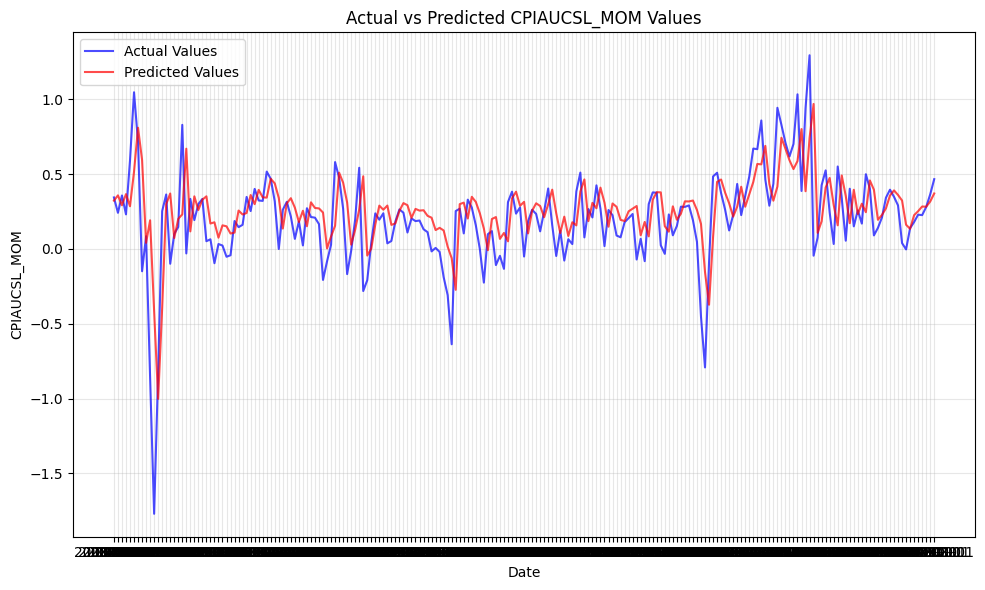

In [13]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))

# Convert to pandas Series for easier plotting with time index
dates = post_2008_df["sasdate"]
y_true_series = pl.Series(y_true_filtered).to_pandas()
y_pred_series = pl.Series(y_pred_filtered).to_pandas()

plt.plot(dates, y_true_filtered, label='Actual Values', color='blue', alpha=0.7)
plt.plot(dates, y_pred_filtered, label='Predicted Values', color='red', alpha=0.7)

plt.xlabel('Date')
plt.ylabel(target)
plt.title(f'Actual vs Predicted {target} Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


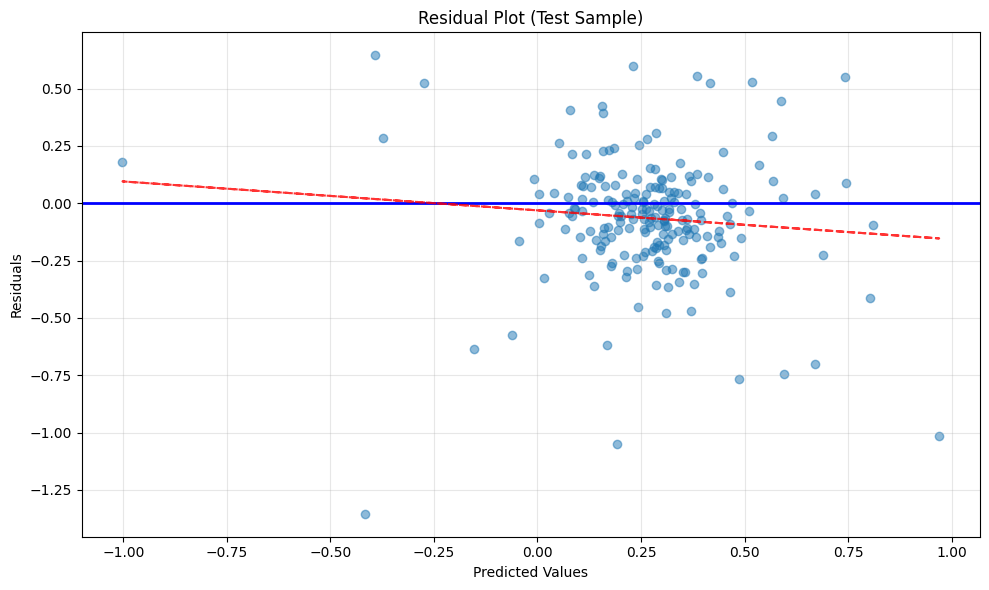

In [14]:
residuals = y_true_filtered - pl.Series(y_pred_filtered.values)

plt.figure(figsize=(10, 6))

plt.scatter(y_pred_filtered, residuals, alpha=0.5)
plt.axhline(y=0, color='b', linestyle='-', linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Test Sample)")
plt.grid(True, alpha=0.3)

z = np.polyfit(y_pred_filtered, residuals, 1)
p = np.poly1d(z)
plt.plot(y_pred_filtered, p(y_pred_filtered), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

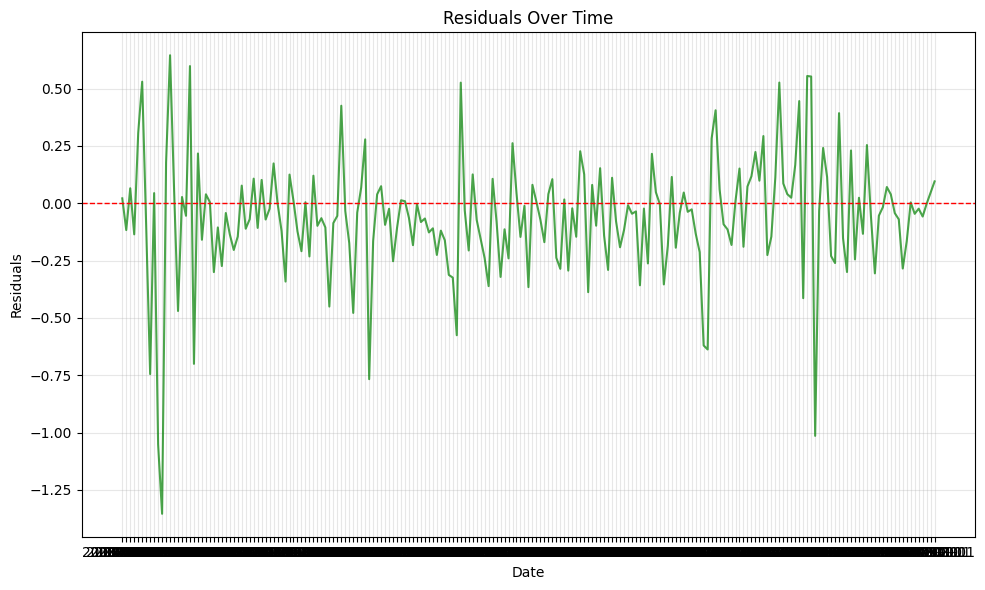

In [16]:
# Plot residuals over time
plt.figure(figsize=(10, 6))

# Use the dates from post_2008_df for the time axis
plt.plot(dates, residuals, color='green', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


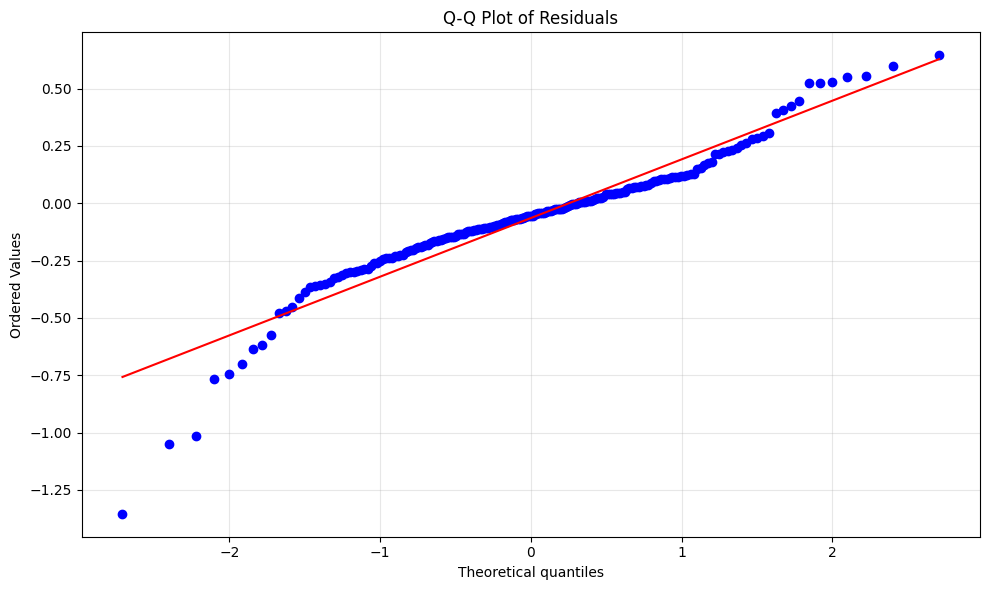

In [15]:
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Ridge Regression

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

target = "CPIAUCSL_MOM"
lag_cols = [col for col in filtered_df.columns if col.endswith("_lag") and col != f"{target}_lag1"]

filtered_df = filtered_df.to_pandas().dropna(subset=lag_cols + [target])



X = filtered_df[lag_cols]
X_scaled = scaler.fit_transform(X)
X_scaled_sm = sm.add_constant(X_scaled)

y = filtered_df[target]


ValueError: at least one array or dtype is required

In [11]:
alpha = 1.0
ridge_model = sm.OLS(y, X_scaled_sm).fit_regularized(alpha=alpha, L1_wt=0.0)  # L1_wt=0.0 means pure ridge (L2)
print(ridge_model.params)

[ 0.09966226 -0.05483016  0.02977437  0.02796152  0.01844894  0.01667557
  0.02623898  0.01473769  0.02003684  0.019286   -0.01220108 -0.01904404
  0.01804668 -0.02576351 -0.00479998  0.01457548  0.01642222  0.01442469
 -0.00298398 -0.01622848  0.02830204  0.01351173  0.02587753  0.0104377
  0.00663889 -0.00596553]


In [12]:
predictions = ridge_model.predict(X_scaled_sm)
residuals = y - predictions
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
r2 = 1 - (np.sum(residuals**2) / np.sum((y - np.mean(y))**2))

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}") 
print(f"R-squared: {r2:.4f}")

MSE: 0.0508
RMSE: 0.2254
R-squared: 0.4995


In [14]:
#Now for testing set
filtered_df_pd = filtered_df.to_pandas().dropna(subset=lag_cols + [target])

X_test = filtered_df_pd[lag_cols]
X_test_scaled = scaler.fit_transform(X_test)

X_test_scaled = sm.add_constant(X_test_scaled)


y_test = filtered_df_pd[target]

y_pred_filtered = ridge_model.predict(X_test_scaled)
mse_filtered = mean_squared_error(y_test, y_pred_filtered)
rmse_filtered = np.sqrt(mse_filtered)

print(f"\nResults for dates between 1970-2005:")
print(f"Mean Squared Error (MSE): {mse_filtered:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_filtered:.6f}")
print(f"R-squared: {r2_filtered:.6f}")



Results for dates between 1970-2005:
Mean Squared Error (MSE): 0.048433
Root Mean Squared Error (RMSE): 0.220075
R-squared: 0.314841


### Ridge with CV we prayyy

In [15]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold

# Setup cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create and fit RidgeCV model
alphas = np.logspace(-6, 6, 13)
ridge_cv = RidgeCV(alphas=alphas, cv=kf, scoring='neg_mean_squared_error')
ridge_cv.fit(X_scaled, y)

# Print best alpha
print(f"Best alpha: {ridge_cv.alpha_}")

Best alpha: 10.0


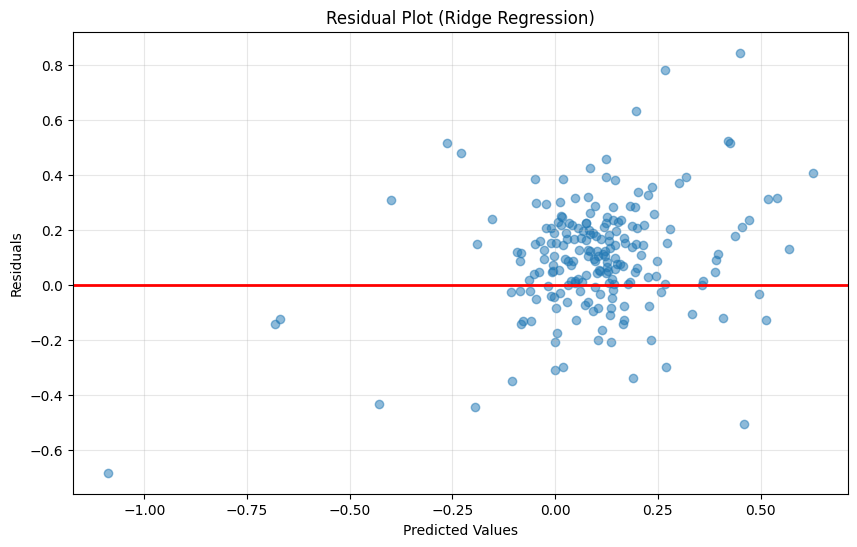

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Ridge Regression)")
plt.grid(True, alpha=0.3)

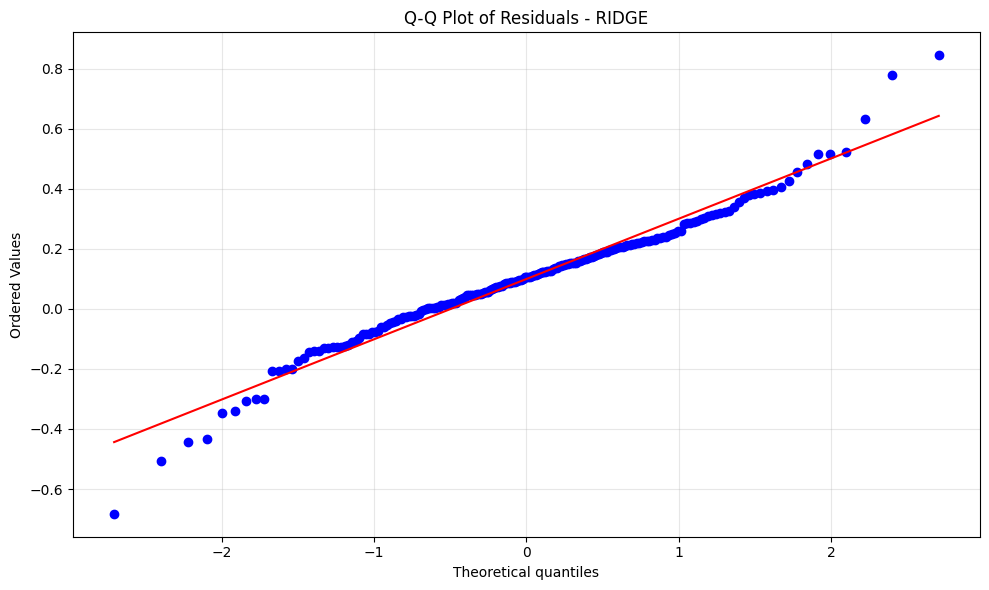

In [17]:
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals - RIDGE")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

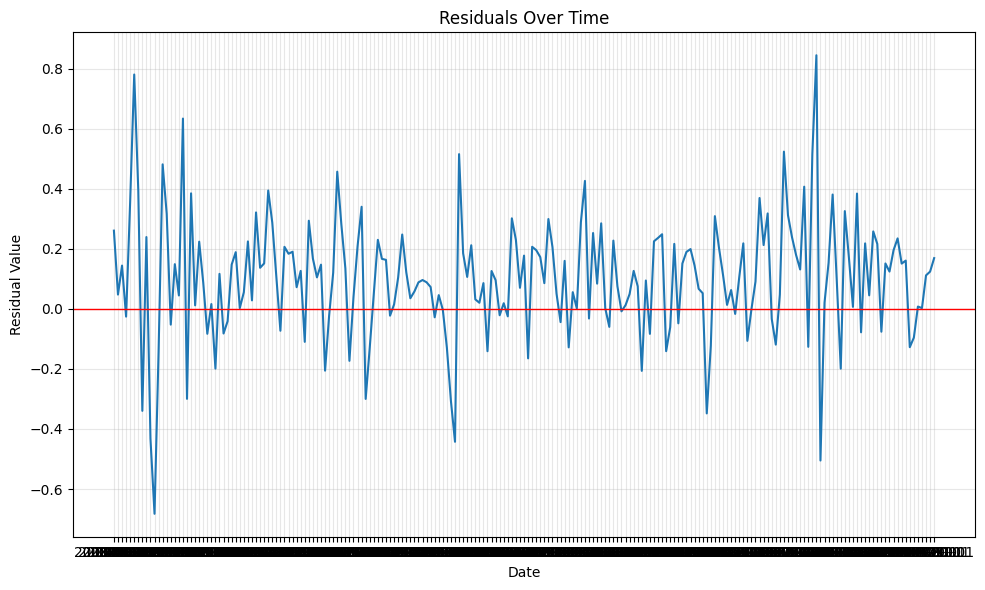

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(post_2008_df_pd['sasdate'], residuals)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()